#### Init Profiler

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from copy import deepcopy
from neuron import h
from bmtool.singlecell import Profiler, Passive, CurrentClamp, FI, ZAP
from scipy.stats import linregress

# path to template and mechs
template_dir = os.path.join('..', 'Network-Parameters' , 'components', 'templates')
mechanism_dir = os.path.join('..', 'Network-Parameters' , 'components', 'mechanisms')

# if not compiled then compile them
if(os.path.exists(mechanism_dir +'/x86_64')==False):
    current_dir = os.getcwd()
    os.chdir(mechanism_dir)
    os.system('nrnivmodl modfiles')
    os.chdir(current_dir)

profiler = Profiler(template_dir=template_dir, mechanism_dir=mechanism_dir, dt = 0.05)


def run_and_plot(sim, title, xlabel, ylabel, plot=True, plot_injection_only=False):
    X, Y = sim.execute()
    X = np.array(X)
    Y = np.array(Y)
    if plot:
        plt.figure()
        if plot_injection_only:
            t_idx = (X >= sim.inj_delay) & (X <= sim.inj_delay + sim.inj_dur)
            plt.plot(X[t_idx], Y[t_idx])
        else:
            plt.plot(X, Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    return X, Y

--No graphics will be displayed.


#### Profiler Settings

In [2]:
noise = False
post_init_function = 'insert_mechs(0)' if noise else None

# CP cell settings
basic_settings = {
    'Passive': {
        'celsius': 26.,
        'kwargs': {
            'inj_amp': -100.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 2500.,
            'method': 'exp2',
        }
    },
    'CurrentClamp': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 250.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 3000.,
            'threshold': -15. #same as what we do in BMTK
        }
    },
    'ZAP': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 100.,
            'inj_delay': 1000.,
            'inj_dur': 15000.,
            'tstop': 15500.,
            'fstart': 0.,
            'fend': 15.,
            'chirp_type': 'linear'
        }
    },
    'FI': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'i_start': 0.,
            'i_stop': 1000.,
            'i_increment': 10.,
            'tstart': 1500.
        }
    }
}
Cell_settings = {cell: deepcopy(basic_settings) for cell in ['CP_Cell', 'CS_Cell', 'FSI_Cell', 'LTS_Cell']}

# CS cell settings
settings = Cell_settings['CS_Cell']
settings['CurrentClamp']['kwargs']['inj_amp'] = 300.

# FSI cell settings
settings = Cell_settings['FSI_Cell']
settings['Passive']['celsius'] = 30.
settings['Passive']['kwargs'] = {'inj_amp': -100., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'method': 'exp2'}
settings['CurrentClamp']['celsius'] = 21.
settings['CurrentClamp']['kwargs'] = {'inj_amp': 200., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'threshold': -15.}
settings['ZAP']['celsius'] = 30.
settings['ZAP']['kwargs']['inj_amp'] = 10.
settings['FI']['celsius'] = 30.
settings['FI']['kwargs']['tstart'] = 500.
# settings['Passive'] = None
# settings['ZAP'] = None
# settings['FI'] = None

# LTS cell settings
settings = Cell_settings['LTS_Cell'] = deepcopy(Cell_settings['FSI_Cell'])
settings['CurrentClamp']['kwargs']['inj_amp'] = 50. 

#### Select Cell

In [3]:
Cell = 'CP_Cell' # CP_Cell CS_Cell FSI_Cell LTS_Cell
settings = Cell_settings[Cell]

#### Passive Properties

In [4]:
proc = settings['Passive']
if proc is not None:
    h.celsius = proc['celsius']
    sim = Passive(Cell, **proc['kwargs'])
    title = 'Passive Cell Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: CP_Cell[0].soma[0](0.5)
Recording: CP_Cell[0].soma[0](0.5)._ref_v


# Ranges for each Type of Cell
### Format for the data in each cell is: Ziao's wanted value (min, max) [current value]
- #### When tuning cells we care more about R_in and FI slope over threshold.

| Cell | Apical Len(um) | V_rest(mV) | R_in(Mohms) | Tau_m(ms) | FI Curve Threshold(pA) | FI Curve Slope(spike/pA) |
|:------|:----------------|:------------|:-------------|:-----------|:------------------------|:--------------------------|
| CP   | 600  | -70 (-66,-75) [-68.99]    | 140 (130,150) [143.84] | 17 (13,22) [21.44] | (50,70) [70] | 0.2 [0.2029]|
| CS | 500 | -70 (-63,-75) [-71.73] | 250 (200,300) [298.78]  | 28 (24,32) [31.89] | (40,50) [50] | 0.18 [0.1975] |
| FSI | 240 (180,380) | -74 (-69,-81) [-74] | 100 (70,130) [104.4] | 5 (2,10) [3.03] | 300 (150,450) [200] | 1.1 (0.6,1.7) [0.7825] |
| LTS | 240 (150,320) | -71 (-66,-76) [-70] | 300 (150,450) [289.81] | 25 (10,45) [19.43] | 50 (20,100) [50] | 0.4 (0.1,0.7) [0.1916] |

##### Allen Cell Types Database https://celltypes.brain-map.org/data?donor__species=Mus%20musculus&nr__reconstruction_type=[full,dendrite-only] 



Running simulation for passive properties...

V Rest: -68.99 (mV)
Resistance: 143.84 (MOhms)
Membrane time constant: 21.44 (ms)

V_rest Calculation: Voltage taken at time 1500.0 (ms) is
-68.99 (mV)

R_in Calculation: dV/dI = (v_final-v_rest)/(i_final-i_start)
(-83.37 - (-68.99)) / (-0.1 - 0)
14.38 (mV) / 0.1 (nA) = 143.84 (MOhms)

Tau Calculation: Fit a double exponential curve to the membrane potential response
f(t) = a0 + a1*exp(-t/tau1) + a2*exp(-t/tau2)
Constained by initial value: f(0) = a0 + a1 + a2 = v_rest
Fit parameters: (a0, a1, a2, tau1, tau2) = (-83.36, -1666.78, 1681.15, 21.44, 21.22)
Membrane time constant is determined from the slowest exponential term: 21.44 (ms)

Sag potential: v_sag = v_peak - v_final = -2.94 (mV)
Normalized sag potential: v_sag / (v_peak - v_rest) = 0.169



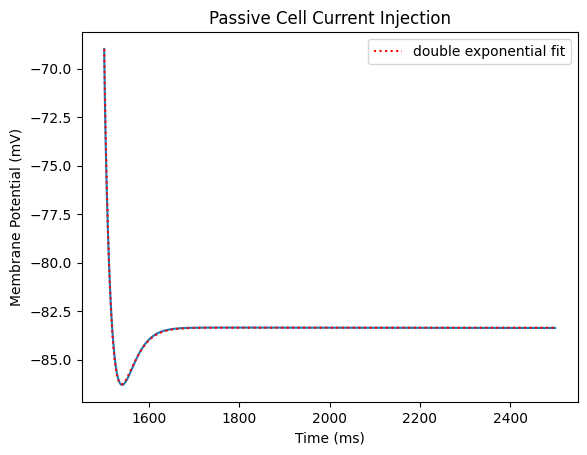

In [5]:
if proc is not None:
    if sim.method == 'exp2':
        X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
        plt.gca().plot(*sim.double_exponential_fit(), 'r:', label='double exponential fit')
        plt.legend()
    else:
        X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
    plt.show()


#### Current Injection

In [6]:
proc = settings['CurrentClamp']
if proc is not None:
    h.celsius = proc['celsius']
    sim2 = CurrentClamp(Cell, **proc['kwargs'])
    title = 'Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: CP_Cell[1].soma[0](0.5)
Recording: CP_Cell[1].soma[0](0.5)._ref_v


Current clamp simulation running...

Number of spikes: 46



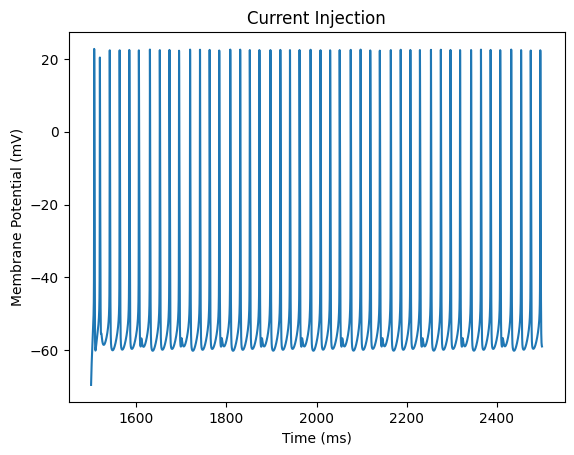

In [7]:
if proc is not None:
    X, Y = run_and_plot(sim2, title, xlabel, ylabel, plot_injection_only=True)
    plt.show()

#### Impedance Amplitude Profile (ZAP)

In [8]:
proc = settings['ZAP']
if proc is not None:
    h.celsius = proc['celsius']
    sim3 = ZAP(Cell, **proc['kwargs'])
    title = 'ZAP Response'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: CP_Cell[2].soma[0](0.5)
Recording: CP_Cell[2].soma[0](0.5)._ref_v


ZAP current simulation running...

Chirp current injection with frequency changing from 0 to 15 Hz over 15 seconds
Impedance is calculated as the ratio of FFT amplitude of membrane voltage to FFT amplitude of chirp current

Resonant Peak Frequency: 0.267 (Hz)


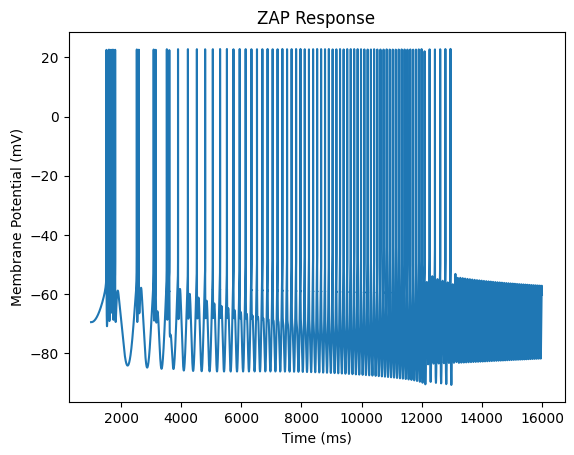

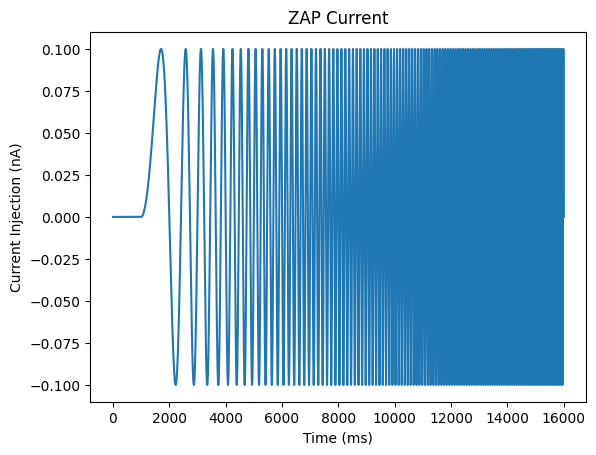

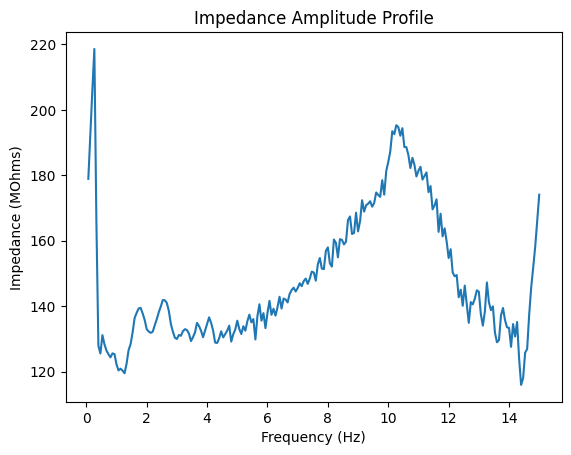

In [9]:
if proc is not None:
    X, Y = run_and_plot(sim3, title, xlabel, ylabel, plot_injection_only=True)

    plt.figure()
    plt.plot(X, sim3.zap_vec)
    plt.title('ZAP Current')
    plt.xlabel('Time (ms)')
    plt.ylabel('Current Injection (nA)')

    plt.figure()
    plt.plot(*sim3.get_impedance(smooth=9))
    plt.title('Impedance Amplitude Profile')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance (MOhms)')
    plt.show()

#### F-I Curve

In [10]:
proc = settings['FI']
if proc is not None:
    h.celsius = proc['celsius']
    sim4 = FI(Cell, **proc['kwargs'])
    title = 'FI Curve'
    xlabel = 'Injection (nA)'
    ylabel = '# Spikes'

Injection location: CP_Cell[102].soma[0](0.5)
Recording: CP_Cell[102].soma[0](0.5)._ref_v


Running simulations for FI curve...

Results
Injection (nA): 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99
Number of spikes: 0, 0, 0, 0, 0, 0, 0, 8, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 42, 44, 46, 48, 50, 52, 55, 57, 60, 62, 65, 69, 6, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1



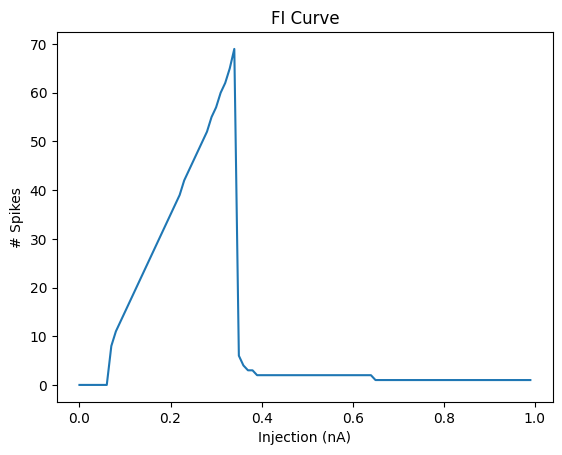

In [11]:
if proc is not None:
    X, Y = run_and_plot(sim4, title, xlabel, ylabel)
    plt.show()
    
#0,0,7....74,7,4,3
#higher slope

#### Cell Stucture

In [12]:
for i in range(Y.size):
    if(Y[i] == 8):
        print(X[i])

0.07


In [13]:
# %matplotlib ipympl
# import numpy as np
# import matplotlib.pyplot as plt
# from neuron import h

# h.load_file("stdrun.hoc")
# h.load_file('templates/templates.hoc')

# def plot_morphology(cell):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     for sec in cell.all:
#         x = [h.x3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         y = [h.y3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         z = [h.z3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         ax.plot(x, y, z, color='k')

#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     plt.show()

# cell = h.CP_Cell()

# plot_morphology(cell)
